In [1]:
import math
import warnings  # Suppress the UserWarning from StandardScaler
import numpy as np
from numpy import array
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout, Input, Attention, Concatenate
from keras.models import Model, Sequential
from scikeras.wrappers import KerasRegressor

In [2]:
#scrap dataset
ticker = 'AAPL'
aaplData = yf.download(ticker, '1981-01-01', '2024-07-18')
aaplData.to_csv('AAPL.csv')

[*********************100%%**********************]  1 of 1 completed


In [3]:
stockPrices = pd.read_csv('AAPL.csv')

### EDA

In [4]:
stockPrices.isnull()

,Date,Open,High,Low,Close,Adj Close,Volume
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
10971,False,False,False,False,False,False,False
10972,False,False,False,False,False,False,False
10973,False,False,False,False,False,False,False
10974,False,False,False,False,False,False,False


In [5]:
stockPrices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10976 entries, 0 to 10975
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10976 non-null  object 
 1   Open       10976 non-null  float64
 2   High       10976 non-null  float64
 3   Low        10976 non-null  float64
 4   Close      10976 non-null  float64
 5   Adj Close  10976 non-null  float64
 6   Volume     10976 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 600.4+ KB


In [6]:
stockPrices.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
stockPrices.shape

(10976, 7)

In [8]:
stockPrices.size

76832

In [9]:
stockPrices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10976.000000,10976.000000,10976.000000,10976.000000,10976.000000,1.097600e+04
mean,22.161091,22.400330,21.932870,22.176149,21.381217,3.185559e+08
std,45.684065,46.176601,45.229793,45.724736,45.295521,3.355959e+08
min,0.049665,0.049665,0.049107,0.049107,0.037900,0.000000e+00
25%,0.299107,0.305140,0.291295,0.299107,0.242771,1.135413e+08
50%,0.531250,0.537946,0.522321,0.531250,0.432579,2.060548e+08
75%,20.162321,20.340001,19.961518,20.159553,17.258480,3.989608e+08
max,236.479996,237.229996,233.089996,234.820007,234.820007,7.421641e+09


In [10]:
stockPrices.isna()

,Date,Open,High,Low,Close,Adj Close,Volume
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
10971,False,False,False,False,False,False,False
10972,False,False,False,False,False,False,False
10973,False,False,False,False,False,False,False
10974,False,False,False,False,False,False,False


### Train-test Split

In [11]:
testRatio = 0.2
trainingRatio = 1 - testRatio

trainingSize = int(trainingRatio * len(stockPrices))
testSize = int(testRatio * len(stockPrices))
print(f"Training Size: {trainingSize}")
print(f"Testing Size: {testSize}")

train = stockPrices[:trainingSize][["Close"]]  
test = stockPrices[trainingSize:][["Close"]].copy() 

Training Size: 8780
Testing Size: 2195


### Feature Engineering

In [12]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i - N: i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [13]:
# Calculate the metrics RMSE and MAPE
def calculateRMSE(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def calculateMAPE(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [14]:
def calculate_perf_metrics(var):
    ### RMSE
    rmse = calculateRMSE(
        np.array(stockPrices[trainingSize:]["Close"]),
        np.array(stockPrices[trainingSize:][var]),
    )
    ### MAPE
    mape = calculateMAPE(
        np.array(stockPrices[trainingSize:]["Close"]),
        np.array(stockPrices[trainingSize:][var]),
    )

    return rmse, mape

In [15]:
def plot_stock_trend(var, cur_title, stockprices=stockPrices):
    ax = stockprices[["Close", var, "200 Days"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

### SMA

RMSE for SMA: 8.015866745366743
MAPE for SMA: 6.07264820120756


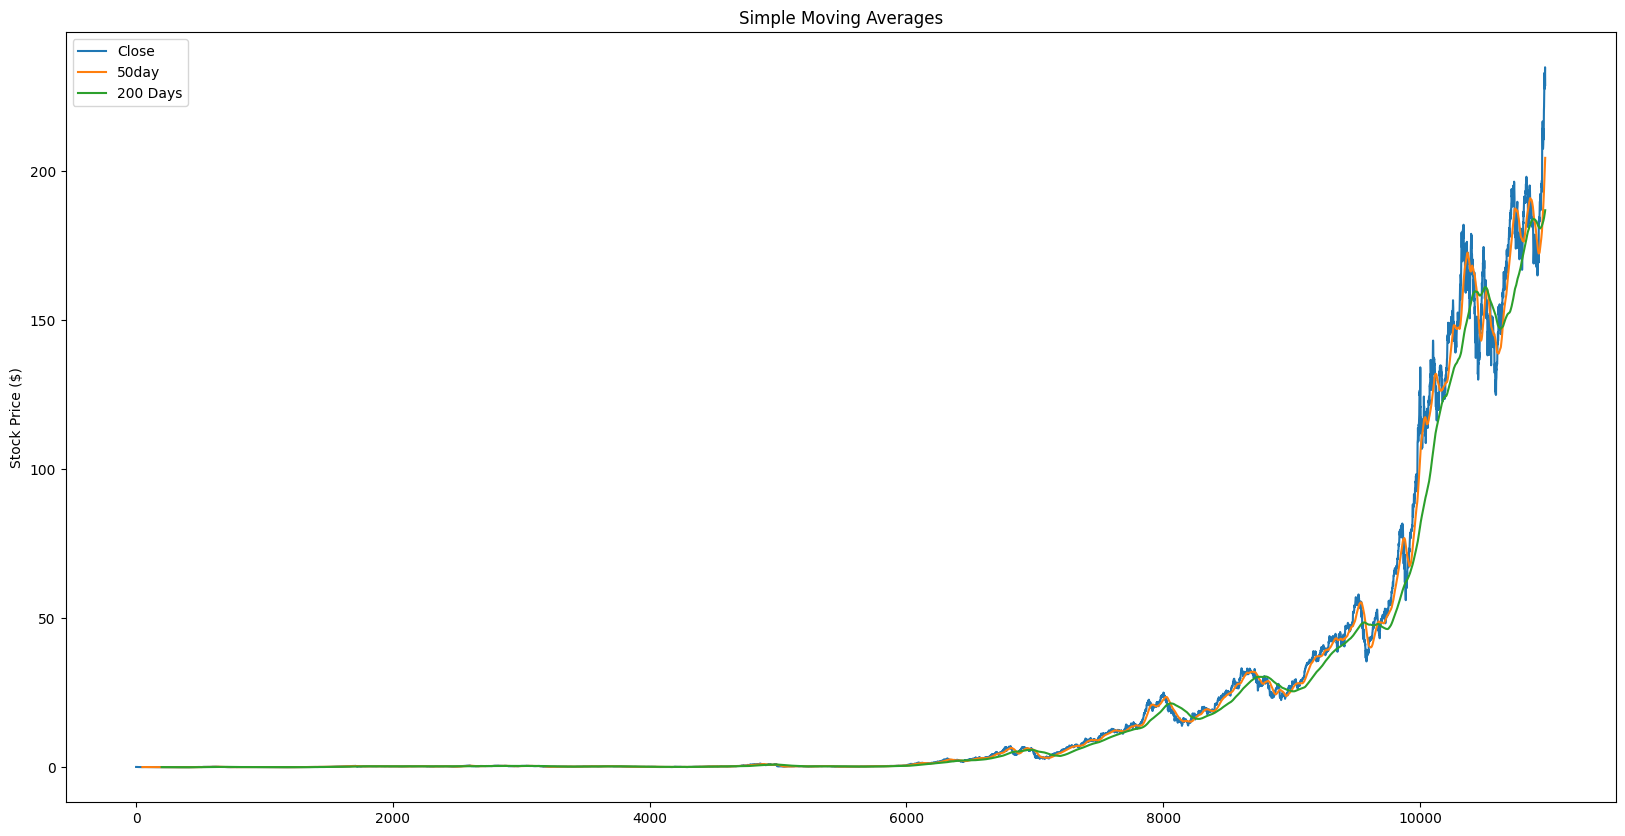

In [16]:
window_size = 50

window_var = f"{window_size}day"

stockPrices[window_var] = stockPrices["Close"].rolling(window_size).mean()

### Include a 200-day SMA for reference
stockPrices["200 Days"] = stockPrices["Close"].rolling(200).mean()

### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title="Simple Moving Averages")
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var)

print(f"RMSE for SMA: {rmse_sma}")
print(f"MAPE for SMA: {mape_sma}")

### EMA

RMSE for EMA: 6.747197993312456
MAPE for EMA: 5.101296296326616


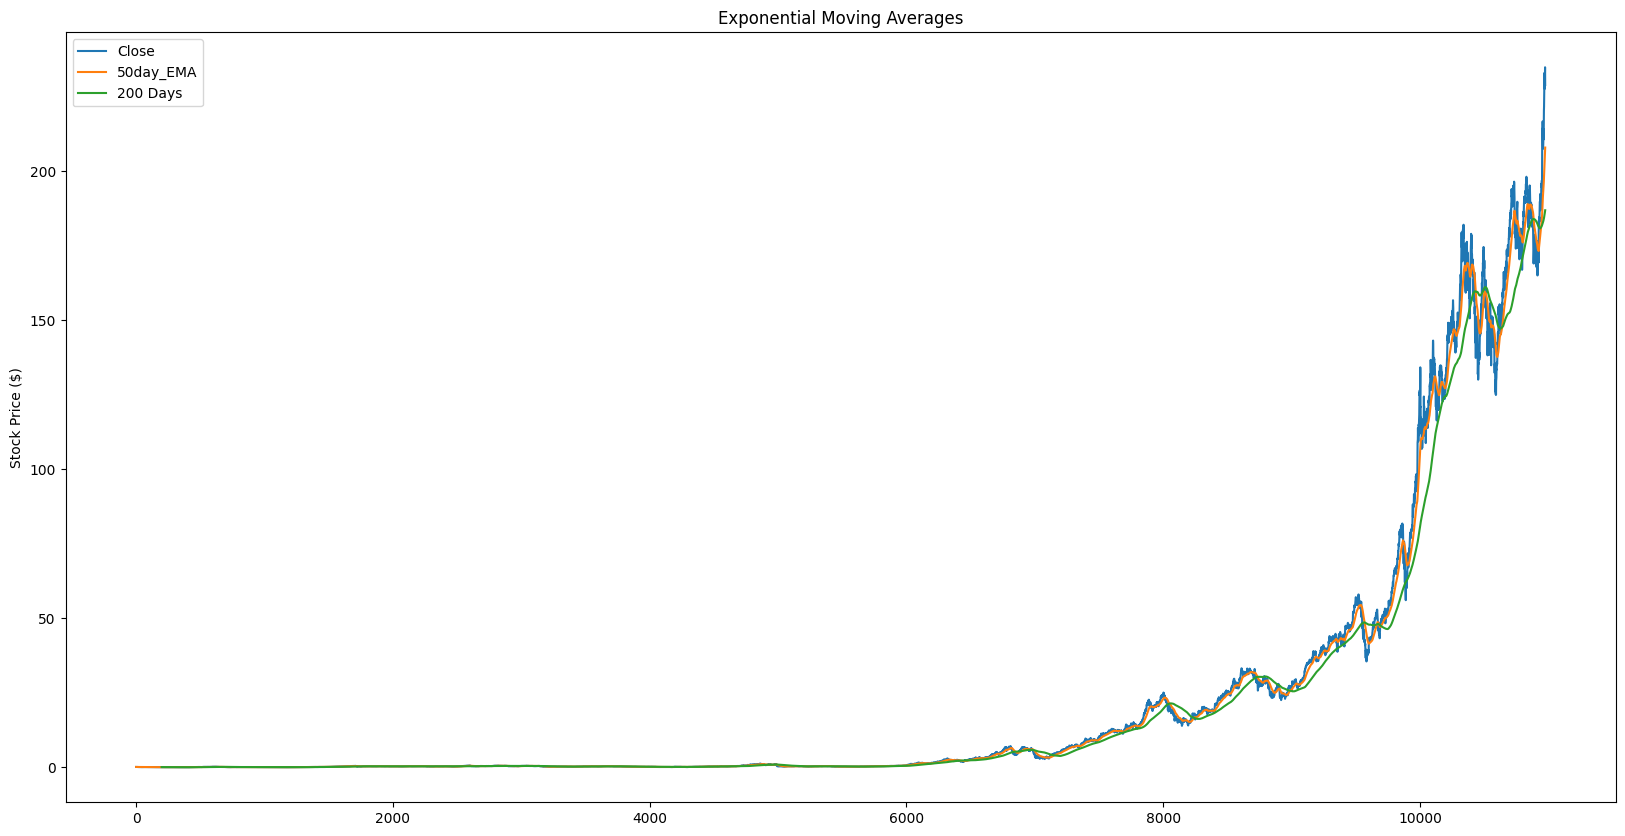

In [17]:
window_ema_var = f"{window_var}_EMA"

# Calculate the 50-day exponentially weighted moving average
stockPrices[window_ema_var] = (
    stockPrices["Close"].ewm(span=window_size, adjust=False).mean()
)
stockPrices["200 Days"] = stockPrices["Close"].rolling(200).mean()

### Plot and performance metrics for EMA model
plot_stock_trend(
    var=window_ema_var, cur_title="Exponential Moving Averages")
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var)

print(f"RMSE for EMA: {rmse_ema}")
print(f"MAPE for EMA: {mape_ema}")

### LSTM 

In [18]:
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockPrices[["Close"]])
scaled_data_train = scaled_data[:train.shape[0]]

window_size = 50  # define window_size variable
# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

In [19]:
def create_model(layer_units=95, dropout_rate=0.2, optimizer='adam'):
    input_shape = (X_train.shape[1], 1) if len(X_train.shape) == 2 else (X_train.shape[1], X_train.shape[2])
    
    # Define the input layer
    inputs = Input(shape=input_shape)
    
    # LSTM layer
    lstm_out = LSTM(units=layer_units, return_sequences=True)(inputs)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    
    # Attention layer
    attention = Attention()([lstm_out, lstm_out])
    
    # Combine LSTM output and attention output
    combined = Concatenate()([lstm_out, attention])
    
    # Final LSTM layer
    final_lstm = LSTM(units=layer_units)(combined)
    final_lstm = Dropout(dropout_rate)(final_lstm)
    
    # Output layer
    outputs = Dense(1)(final_lstm)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

### Hyperparameter Tuning

In [20]:
model = KerasRegressor(
    model=create_model,
    layer_units=50,
    dropout_rate=0.3,
    optimizer='adam',
    batch_size=32,
    epochs=50,
    verbose=1  
)

In [21]:
param_grid = {
    'layer_units': [80],
    'dropout_rate': [0.1],
    'batch_size': [128],
    'epochs': [10, 20, 30, 40, 50, 80]
}

In [22]:
try:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1)
    grid_result = grid.fit(X_train, y_train)
    print("Best parameters found: ", grid_result.best_params_)
    print("Best score: ", grid_result.best_score_)
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Error type:", type(e))
    print("Error args:", e.args)
    import traceback
    traceback.print_exc()

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0348
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 7.1010e-04
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 6.0405e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 5.3179e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 4.9676e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 4.9748e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 4.4262e-04
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 4.4253e-04
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 4.1709e-04
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 3.9274e-04
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0466
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 9.2816e-04
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 6.2180e-

In [23]:
best_params = {k.replace('model__', ''): v for k, v in grid_result.best_params_.items()}
print("Best parameters found: ", best_params)

Best parameters found:  {'batch_size': 128, 'dropout_rate': 0.1, 'epochs': 30, 'layer_units': 80}


In [24]:
final_model = create_model(
    layer_units=best_params['layer_units'],
    dropout_rate=best_params['dropout_rate'],
    optimizer='adam'
)

In [25]:
final_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 50, 80)    │     26,240 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 50, 80)    │          0 │ lstm_26[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_13        │ (None, 50, 80)    │          0 │ dropout_26[0][0], │
│ (Attention)         │                   │            │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 50, 160)   │          0 │ dropout_26[0][0], │
│ (Concatenate)       │                   │            │ attention_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 80)        │     77,120 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 80)        │          0 │ lstm_27[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         81 │ dropout_27[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,441 (404.07 KB)

 Trainable params: 103,441 (404.07 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Callbacks - to prevent overfitting by cutting short epochs and save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('predictionAttentionMechanism.keras', monitor='val_loss', save_best_only=True)

In [27]:
history = final_model.fit(
    X_train,
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    verbose=1,
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0368 - val_loss: 0.0054
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 6.2025e-04 - val_loss: 0.0054
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 5.3050e-04 - val_loss: 0.0047
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 5.3525e-04 - val_loss: 0.0044
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 4.9117e-04 - val_loss: 0.0038
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 4.5895e-04 - val_loss: 0.0034
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 4.5561e-04 - val_loss: 0.0029
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 4.2885e-04 - val_loss: 0.0024
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 4.0622e-04 - val_loss: 0.0021
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 4.0114e-04 - val_loss: 0.0017
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 3.9882e-04 - val_loss: 0.0014
Epoch 12/30
55/55 ━━━━━

In [28]:
best_model = grid_result.best_estimator_

In [29]:
# Preprocess test data
def preprocess_testdat(data=stockPrices, scaler=scaler, window_size=window_size, test=test):
    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1, 1)
    raw = scaler.transform(raw)

    X_test = [raw[i - window_size: i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat().astype('float32')

# Use the best model from grid search for predictions
predicted_price_ = best_model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Ensure test DataFrame has a column to store predictions
test["Predictions_lstm"] = predicted_price

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [30]:
# Evaluate performance
rmse_lstm = calculateRMSE(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = calculateMAPE(np.array(test["Close"]), np.array(test["Predictions_lstm"]))

print(f"RMSE for LSTM: {rmse_lstm}")
print(f"MAPE for LSTM: {mape_lstm}")

RMSE for LSTM: 31.812484539726906
MAPE for LSTM: 15.713040855673075


In [31]:
def plot_stock_trend_lstm(train, test):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(train.index, train["Close"], label="Train Closing Price")
    ax.plot(test.index, test["Close"], label="Test Closing Price")
    ax.plot(test.index, test["Predictions_lstm"], label="Predicted Closing Price")
    ax.set_title("LSTM Model")
    ax.set_xlabel("Date")
    ax.set_ylabel("Stock Price (USD $)")
    ax.legend()
    plt.show()

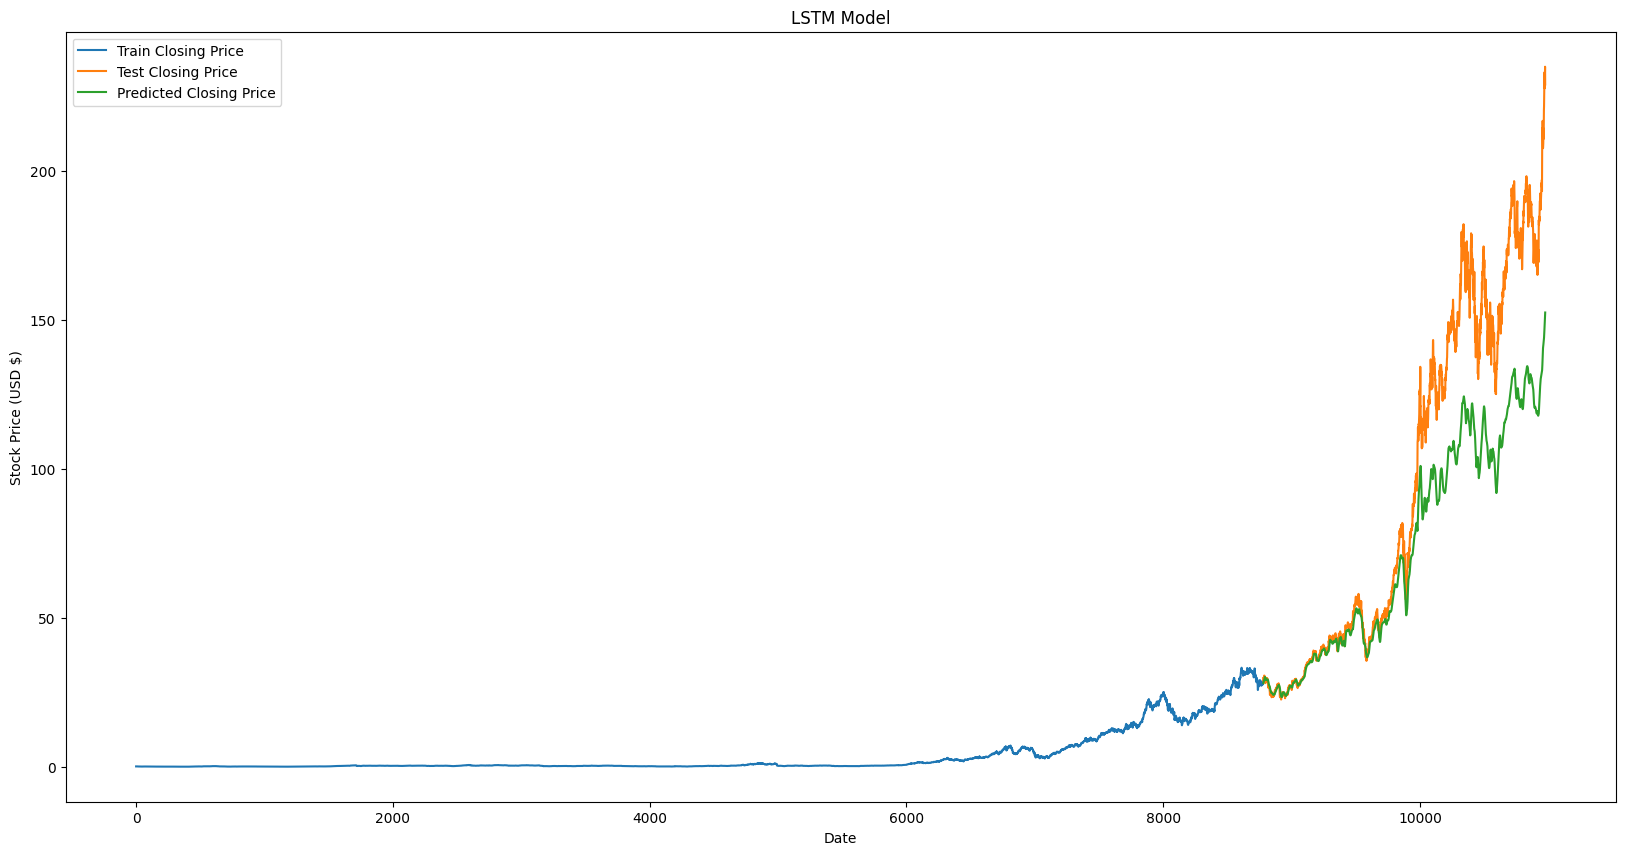

In [32]:
plot_stock_trend_lstm(train, test)